### Plot survival curves

Just for BRCA now, as a sanity check.

In [1]:
import os
import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

In [2]:
cancer_type = 'BRCA'
signal = 'signal'

functions_dir = os.path.join(cfg.repo_root, 'test_results_10')
samples, fns = au.load_survival_curves(functions_dir, cancer_type, signal=signal)

print(len(samples), len(fns))

673 673


In [3]:
# get clinical info for BRCA samples
# this includes age, subtype, etc.
clinical_df = pd.read_excel(cfg.clinical_data,
                            sheet_name='TCGA-CDR',
                            index_col='bcr_patient_barcode',
                            engine='openpyxl')

clinical_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
clinical_df.rename(columns={'age_at_initial_pathologic_diagnosis': 'age'}, inplace=True)

print(clinical_df.shape)
clinical_df.head()

(11160, 32)


,type,age,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2004.0,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2008.0,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


### Color survival curves by age

Here, we discretize age into quantiles, and color the survival curves by quantile. We'd expect older patients to have shorter/poorer survival in general.

In [4]:
ages = clinical_df.loc[(clinical_df.type == cancer_type) & (~clinical_df.age.isna()), 'age']
print(ages.isna().sum())
ages.head()

0


bcr_patient_barcode
TCGA-3C-AAAU    55.0
TCGA-3C-AALI    50.0
TCGA-3C-AALJ    62.0
TCGA-3C-AALK    52.0
TCGA-4H-AAAK    50.0
Name: age, dtype: float64

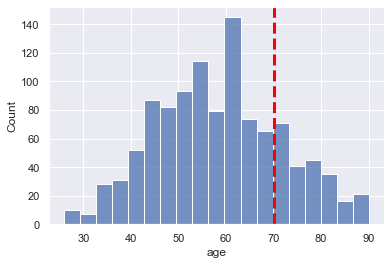

In [5]:
sns.set()
sns.histplot(ages)
qs_age = []
for q in [0.8]:
    q_age = np.quantile(ages, q)
    qs_age.append(q_age)
    plt.gca().axvline(q_age, color='red', linestyle='--', linewidth=3)

In [6]:
age_quantiles = np.digitize(ages.values, qs_age)
ages = pd.DataFrame(ages)
ages['age_quantile'] = age_quantiles
ages.head(n=10)

,age,age_quantile
bcr_patient_barcode,,
TCGA-3C-AAAU,55.0,0
TCGA-3C-AALI,50.0,0
TCGA-3C-AALJ,62.0,0
TCGA-3C-AALK,52.0,0
TCGA-4H-AAAK,50.0,0
TCGA-5L-AAT0,42.0,0
TCGA-5L-AAT1,63.0,0
TCGA-5T-A9QA,52.0,0
TCGA-A1-A0SB,70.0,1


Text(0, 0.5, 'Predicted survival probability')

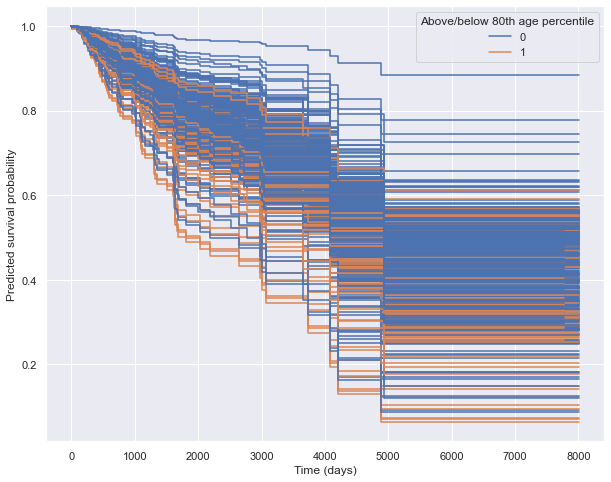

In [7]:
sns.set({'figure.figsize': (10, 8)})

# color by age binned into quantiles
for ix in range(len(fns)):
    try:
        fn = fns[ix]
        sample_id = '-'.join(samples[ix].split('-')[:3])
        sample_age_quantile = int(ages.loc[sample_id, 'age_quantile'])
        plt.step(fn.x, fn.y, label=sample_age_quantile,
                 color='C{:d}'.format(sample_age_quantile))
    except KeyError:
        continue
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Above/below 80th age percentile')
plt.xlabel('Time (days)')
plt.ylabel('Predicted survival probability')

### Color survival curves by stage at diagnosis

Here, we color the survival curves by cancer stage at diagnosis. We'd expect patients diagnosed at a later stage to have shorter/poorer survival in general.

In [8]:
stages = clinical_df.loc[(clinical_df.type == cancer_type) & (~clinical_df.age.isna()),
                          'ajcc_pathologic_tumor_stage']
print(stages.unique())
print(stages.isna().sum())
stages.head()

['Stage X' 'Stage IIB' 'Stage IA' 'Stage IIIA' 'Stage IIA' 'Stage IV'
 'Stage I' 'Stage IIIC' 'Stage IB' 'Stage IIIB' '[Discrepancy]'
 'Stage III' 'Stage II' '[Not Available]']
0


bcr_patient_barcode
TCGA-3C-AAAU       Stage X
TCGA-3C-AALI     Stage IIB
TCGA-3C-AALJ     Stage IIB
TCGA-3C-AALK      Stage IA
TCGA-4H-AAAK    Stage IIIA
Name: ajcc_pathologic_tumor_stage, dtype: object

Text(0, 0.5, 'Predicted survival probability')

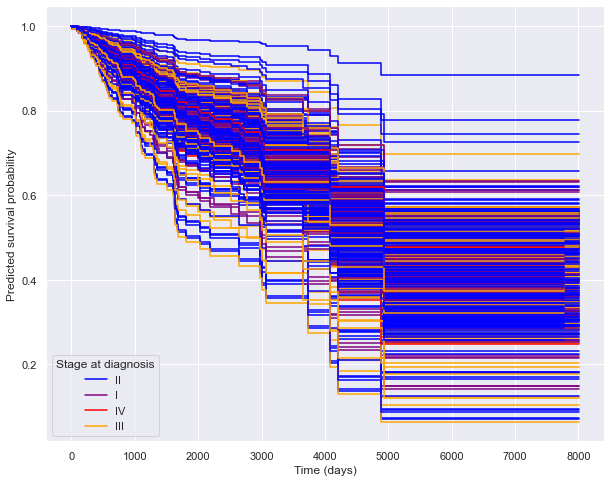

In [9]:
sns.set({'figure.figsize': (10, 8)})

colors = ['purple', 'blue', 'orange', 'red']

# color by stage at diagnosis
for ix in range(len(fns)):
    try:
        fn = fns[ix]
        sample_id = '-'.join(samples[ix].split('-')[:3])
        sample_stage = stages.loc[sample_id]
        short_stage = None
        if sample_stage.startswith('Stage III'):
            short_stage = 'III'
            stage_ix = 2
        elif sample_stage.startswith('Stage IV'):
            short_stage = 'IV'
            stage_ix = 3
        elif sample_stage.startswith('Stage II'):
            short_stage = 'II'
            stage_ix = 1
        elif sample_stage.startswith('Stage I'):
            short_stage = 'I'
            stage_ix = 0
        if short_stage is not None:
            plt.step(fn.x, fn.y, drawstyle='steps-pre', color=colors[stage_ix],
                     label=short_stage)
    except KeyError:
        continue
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Stage at diagnosis')
plt.xlabel('Time (days)')
plt.ylabel('Predicted survival probability')

### Color survival curves by cancer subtype

Here, we color the survival curves by cancer subtype. Generally, there are pronounced differences in survival between subtypes of any given cancer, although the exact differences depend on the cancer type.

In [10]:
sample_freeze_df = du.load_pancancer_data()[0]
sample_freeze_df.head()

,PATIENT_BARCODE,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,TCGA-OR-A5J1,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,TCGA-OR-A5J2,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,TCGA-OR-A5J3,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,TCGA-OR-A5J5,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,TCGA-OR-A5J6,TCGA-OR-A5J6-01,ACC,Not_Applicable


In [11]:
subtypes = sample_freeze_df[sample_freeze_df.DISEASE == cancer_type].SUBTYPE.unique()
subtype_to_ix = {st: ix for ix, st in enumerate(sorted(subtypes))}
print(subtype_to_ix)

{'Basal': 0, 'Her2': 1, 'LumA': 2, 'LumB': 3, 'Normal': 4}


Text(0, 0.5, 'Predicted survival probability')

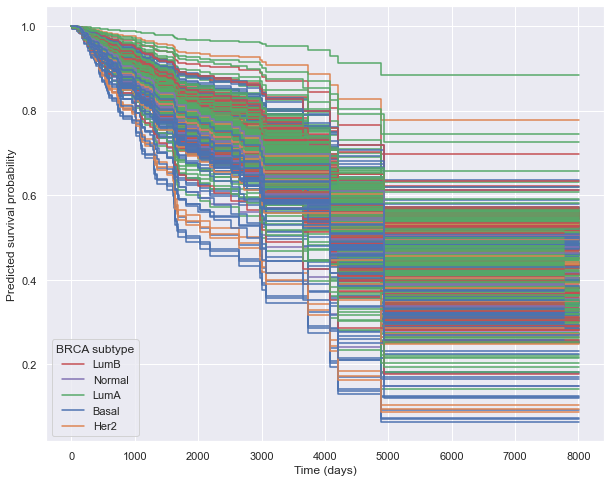

In [12]:
sns.set({'figure.figsize': (10, 8)})

# color by stage at diagnosis
for ix in range(len(fns)):
    try:
        fn = fns[ix]
        sample_id = '-'.join(samples[ix].split('-')[:3])
        subtype = (sample_freeze_df
          .loc[sample_freeze_df.PATIENT_BARCODE == sample_id, 'SUBTYPE']
          .values[0]
        )
        plt.step(fn.x, fn.y, label=subtype,
                 color=sns.color_palette()[subtype_to_ix[subtype]])
    except KeyError:
        continue
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='{} subtype'.format(cancer_type))
plt.xlabel('Time (days)')
plt.ylabel('Predicted survival probability')